# SWITCH THE TRACE

In [1]:
import os
import sys
import json
import pickle as pkl
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import theano
import theano.tensor as T
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../")
from mcmc_utils import *

In [3]:
# read data
fp = os.path.abspath('../dataset/model_set.csv')
raw_df = pd.read_csv(fp)

# feature engineering
raw_df["LogSalePrice"] = np.log(raw_df.SalePrice)
raw_df.CentralAir = [1 if i == "Y" else 0 for i in raw_df.CentralAir]
raw_df["StoneVnr"] = [1 if i == "Stone" else 0 for i in raw_df.MasVnrType]
kitch_qual_conv = {"Ex": 3, "Gd": 2, "TA": 1, "Fa": 0}
raw_df.KitchenQual = [kitch_qual_conv[i] for i in raw_df.KitchenQual]
raw_df.YrSold = raw_df.YrSold - raw_df.YrSold.min()  # years from 2006
raw_df.YearBuilt = raw_df.YearBuilt - raw_df.YearBuilt.min()  # years from 1872
raw_df.YearRemodAdd = raw_df.YearRemodAdd - raw_df.YearRemodAdd.min()  # years from 1950
Neighborhoods = raw_df.Neighborhood.unique()
NbdLookup = dict(zip(Neighborhoods, range(Neighborhoods.size)))
raw_df["NeighborhoodCode"] = raw_df.Neighborhood.replace(NbdLookup)

# drop unecessary cols
d_cols = ["Utilities"]
raw_df.drop(columns=d_cols, inplace=True)

### data preparation and formatting ###

# design matix
covariates = ("1stFlrSF", "LotArea", "StoneVnr", "KitchenQual")
y = raw_df.LogSalePrice
X = raw_df.loc[:, covariates]
X_nbd = raw_df.loc[:, "NeighborhoodCode"]
n_nbd = Neighborhoods.size
n, p = X.shape

# train-test split
train_idx, test_idx = train_test_split(range(n),
                                       test_size=0.2,
                                       random_state=1)
X_train = X.iloc[train_idx, :].reset_index(drop=True)
X_nbd_train = X_nbd.iloc[train_idx].reset_index(drop=True)
X_test = X.iloc[test_idx, :].reset_index(drop=True)
X_nbd_test = X_nbd.iloc[test_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

In [4]:
### modeling ###
hp_model = pm.Model()

Ip_mat = np.eye(p)
zp_vec = np.zeros(p)

with hp_model:
    X_train_data = pm.Data("X_train_data", X_train)
    nbd_idx = pm.Data("nbd_idx", X_nbd_train)
    y_train_data = pm.Data("y_train_data", y_train)
    # hyper priors
    chol, corr, stds = pm.LKJCholeskyCov("Omega", n=p, eta=1.,
                                         sd_dist=pm.Gamma.dist(alpha=7.5, beta=1.0),
                                         compute_corr=True)
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    tau_alpha = pm.Gamma("tau_alpha", alpha=7.5, beta=1.0)
    alpha = pm.Normal("alpha", mu=12., sigma=np.sqrt(1/tau_alpha))
    # priors
    alpha_nbd = pm.Normal("alpha_nbd",
                          mu=alpha,
                          sigma=tau_alpha,
                          shape=(n_nbd,))
    beta_uc = pm.MvNormal("beta_uc", mu=zp_vec, cov=Ip_mat, shape=(p,))
    beta = pm.Deterministic("beta", cov.dot(beta_uc))
    sigma = pm.HalfStudentT("sigma", sigma=0.5, nu=1.)
    # likelihood
    Ey_x = T.add(alpha_nbd[nbd_idx], X_train_data.dot(beta))  # E[Y|X]
    y_obs = pm.Normal("y_obs", mu=Ey_x, sigma=sigma, observed=y_train_data)

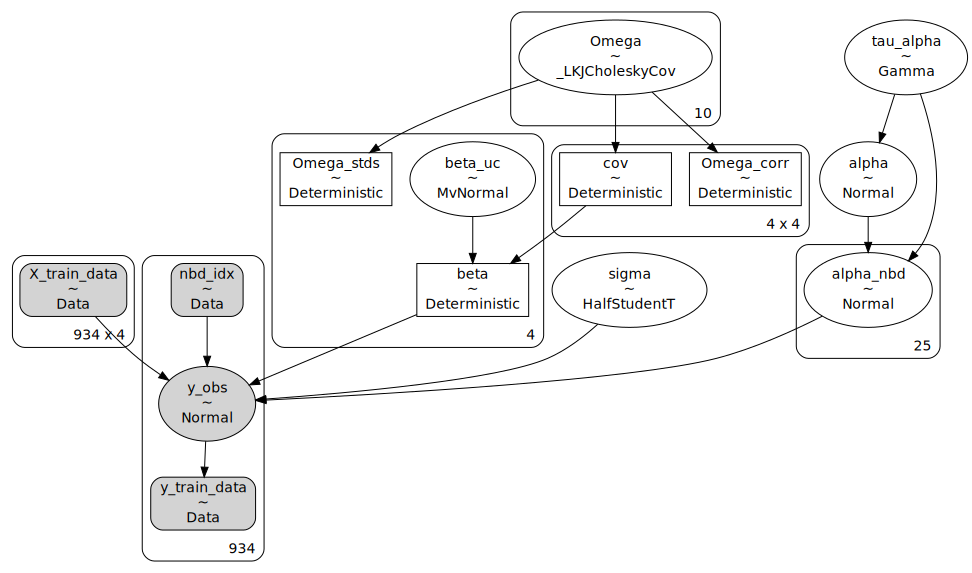

In [5]:
pm.model_to_graphviz(hp_model)

In [6]:
trace = pm.load_trace("../.pymc_2.trace/", model=hp_model)
trace = az.from_pymc3(trace, model=hp_model)
trace_df = trace.to_dataframe()

/home/samvoisin/anaconda3/envs/house_price/lib/python3.8/site-packages/arviz/data/io_pymc3.py:329: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


#### if loading from netCDF
trace = az.from_netcdf("./inf_data.nc")

trace_df = trace.to_dataframe()

In [7]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

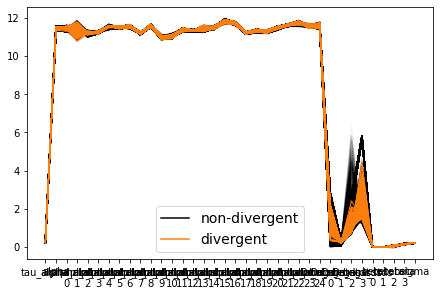

In [8]:
az.plot_parallel(trace, var_names=["tau_alpha", "alpha", "alpha_nbd", "Omega_stds", "beta", "sigma"]);

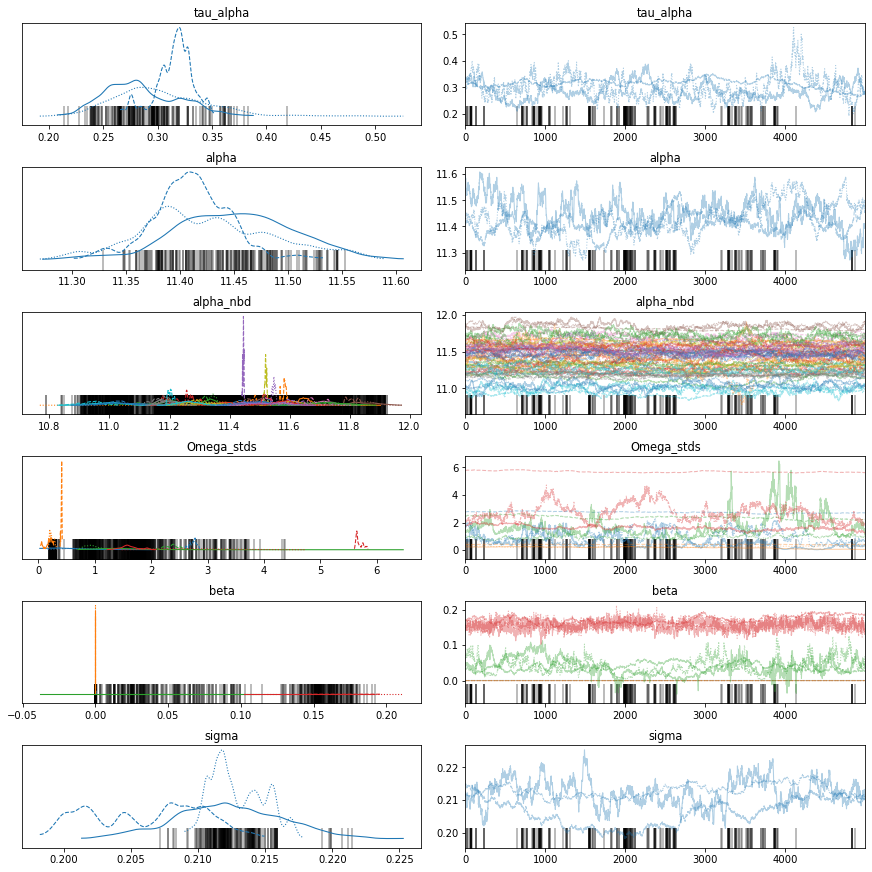

In [9]:
az.plot_trace(trace, var_names=["tau_alpha", "alpha", "alpha_nbd", "Omega_stds", "beta", "sigma"]);

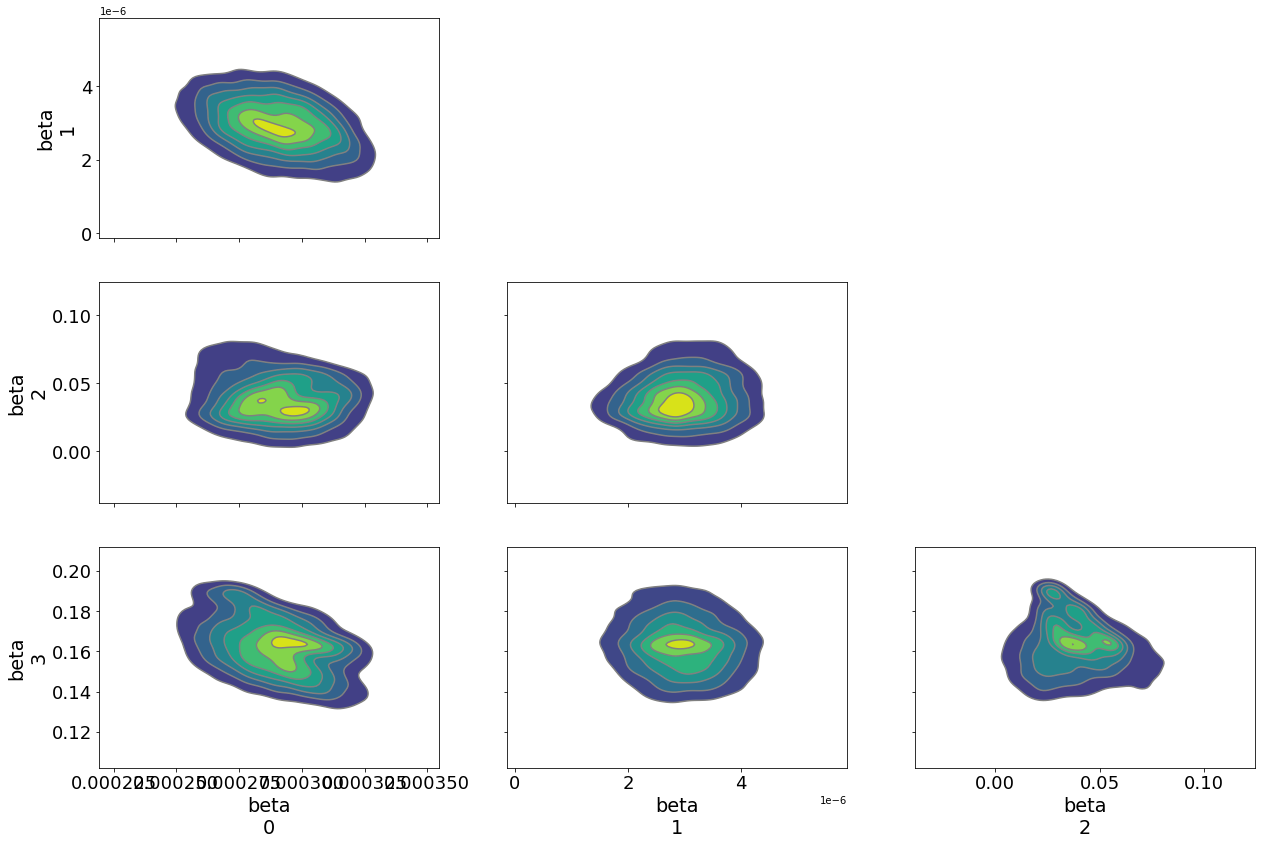

In [10]:
az.plot_pair(trace,
             var_names=['beta'],
             kind='kde',
             divergences=False,
             textsize=18);

1stFlrSF
rhat for 1stFlrSF coef: 1.067194880020663


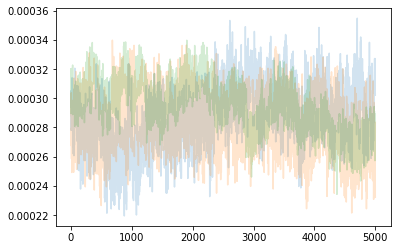

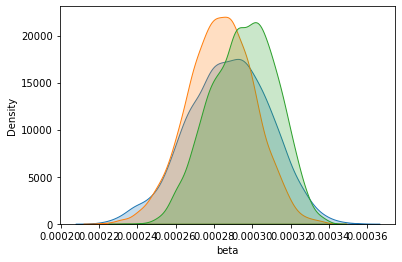

--------
LotArea
rhat for LotArea coef: 1.0362630989081205


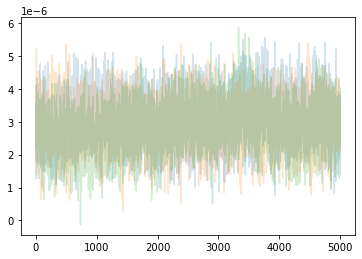

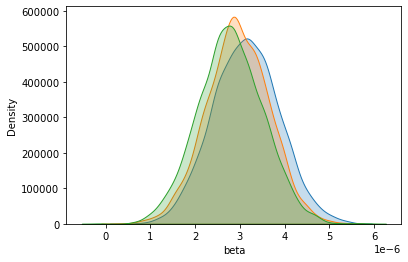

--------
StoneVnr
rhat for StoneVnr coef: 1.0053029569956329


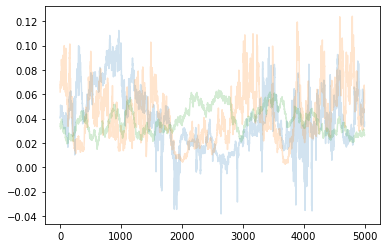

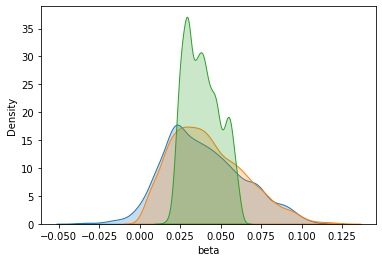

--------
KitchenQual
rhat for KitchenQual coef: 1.4117488132303357


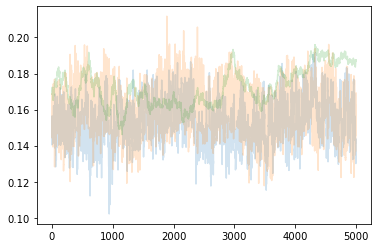

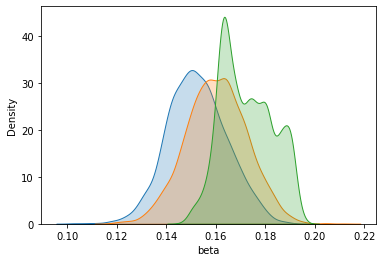

--------


In [11]:
for i, c in enumerate(covariates):
    print(c)
    bi_rhat = calc_Rhat(trace.posterior.beta[0,:,i].values,
                        trace.posterior.beta[1,:,i].values,
                        trace.posterior.beta[2,:,i].values)
    print(f"rhat for {c} coef: {bi_rhat}")
    plot_trace(trace.posterior.beta[0,:,i],
               trace.posterior.beta[1,:,i],
               trace.posterior.beta[2,:,i])
    plot_posterior_dists(trace.posterior.beta[0,:,i],
                         trace.posterior.beta[1,:,i],
                         trace.posterior.beta[2,:,i])
    print("--------")

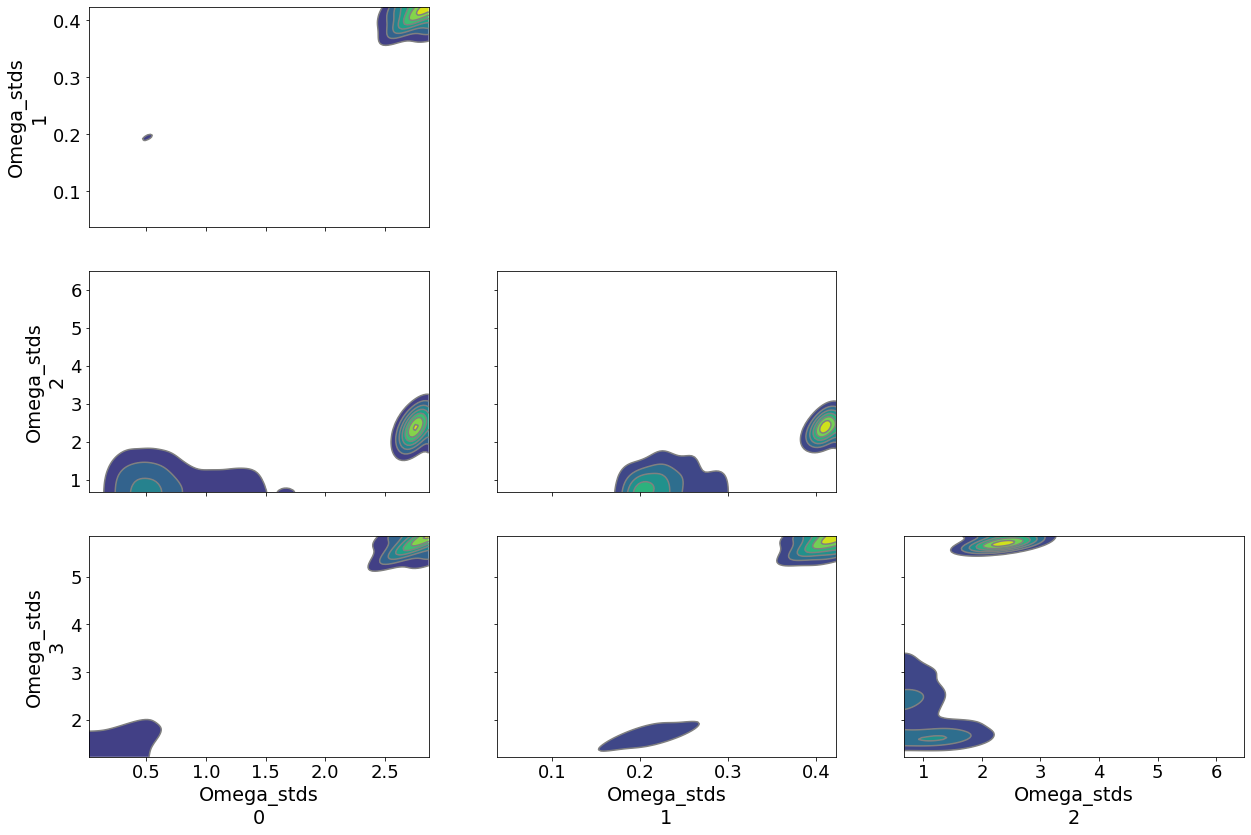

In [12]:
az.plot_pair(trace,
             var_names=['Omega_stds'],
             kind='kde',
             divergences=False,
             textsize=18)
plt.show()

1stFlrSF
rhat for 1stFlrSF coef std: 3.527482006425577


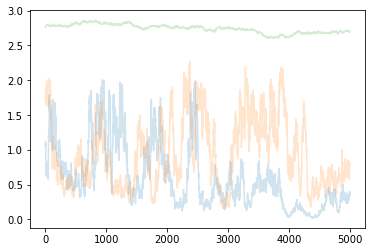

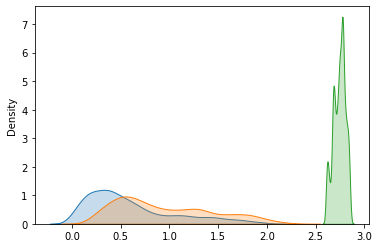

--------
LotArea
rhat for LotArea coef std: 3.31383722267293


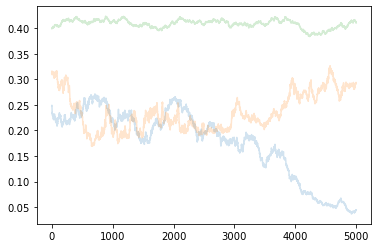

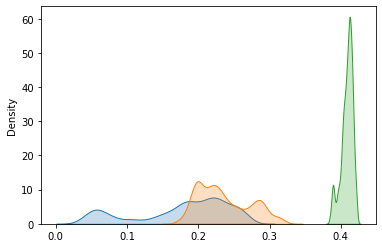

--------
StoneVnr
rhat for StoneVnr coef std: 1.9858679854776995


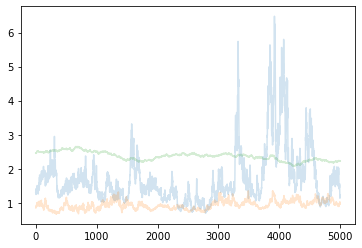

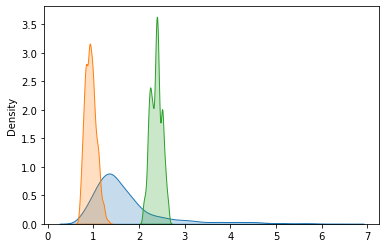

--------
KitchenQual
rhat for KitchenQual coef std: 6.652082705799489


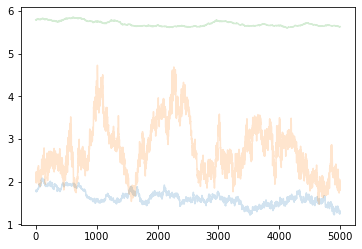

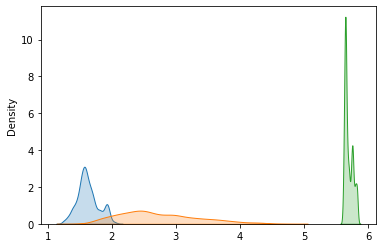

--------


In [13]:
for i, c in enumerate(covariates):
    print(c)
    bi_rhat = calc_Rhat(trace.posterior.Omega_stds[0,:,i].values,
                        trace.posterior.Omega_stds[1,:,i].values,
                        trace.posterior.Omega_stds[2,:,i].values)
    print(f"rhat for {c} coef std: {bi_rhat}")
    plot_trace(trace.posterior.Omega_stds[0,:,i].values,
               trace.posterior.Omega_stds[1,:,i].values,
               trace.posterior.Omega_stds[2,:,i].values)
    plot_posterior_dists(trace.posterior.Omega_stds[0,:,i].values,
                         trace.posterior.Omega_stds[1,:,i].values,
                         trace.posterior.Omega_stds[2,:,i].values)
    print("--------")

Rhat for population alpha 1.0927232315118707


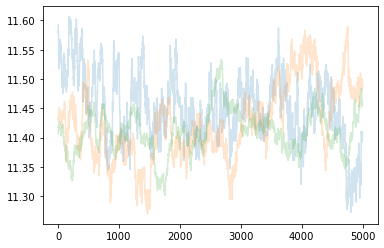

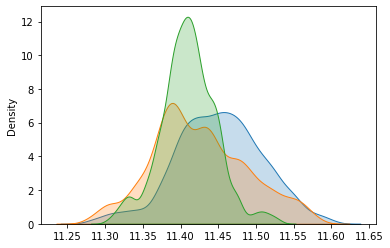

In [14]:
alpha_rhat = calc_Rhat(trace.posterior.alpha[0,:].values,
                       trace.posterior.alpha[1,:].values,
                       trace.posterior.alpha[2,:].values)
print(f"Rhat for population alpha {alpha_rhat}")
plot_trace(trace.posterior.alpha[0,:].values,
           trace.posterior.alpha[1,:].values,
           trace.posterior.alpha[2,:].values)
plot_posterior_dists(trace.posterior.alpha[0,:].values,
                     trace.posterior.alpha[1,:].values,
                     trace.posterior.alpha[2,:].values)

/home/samvoisin/anaconda3/envs/house_price/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


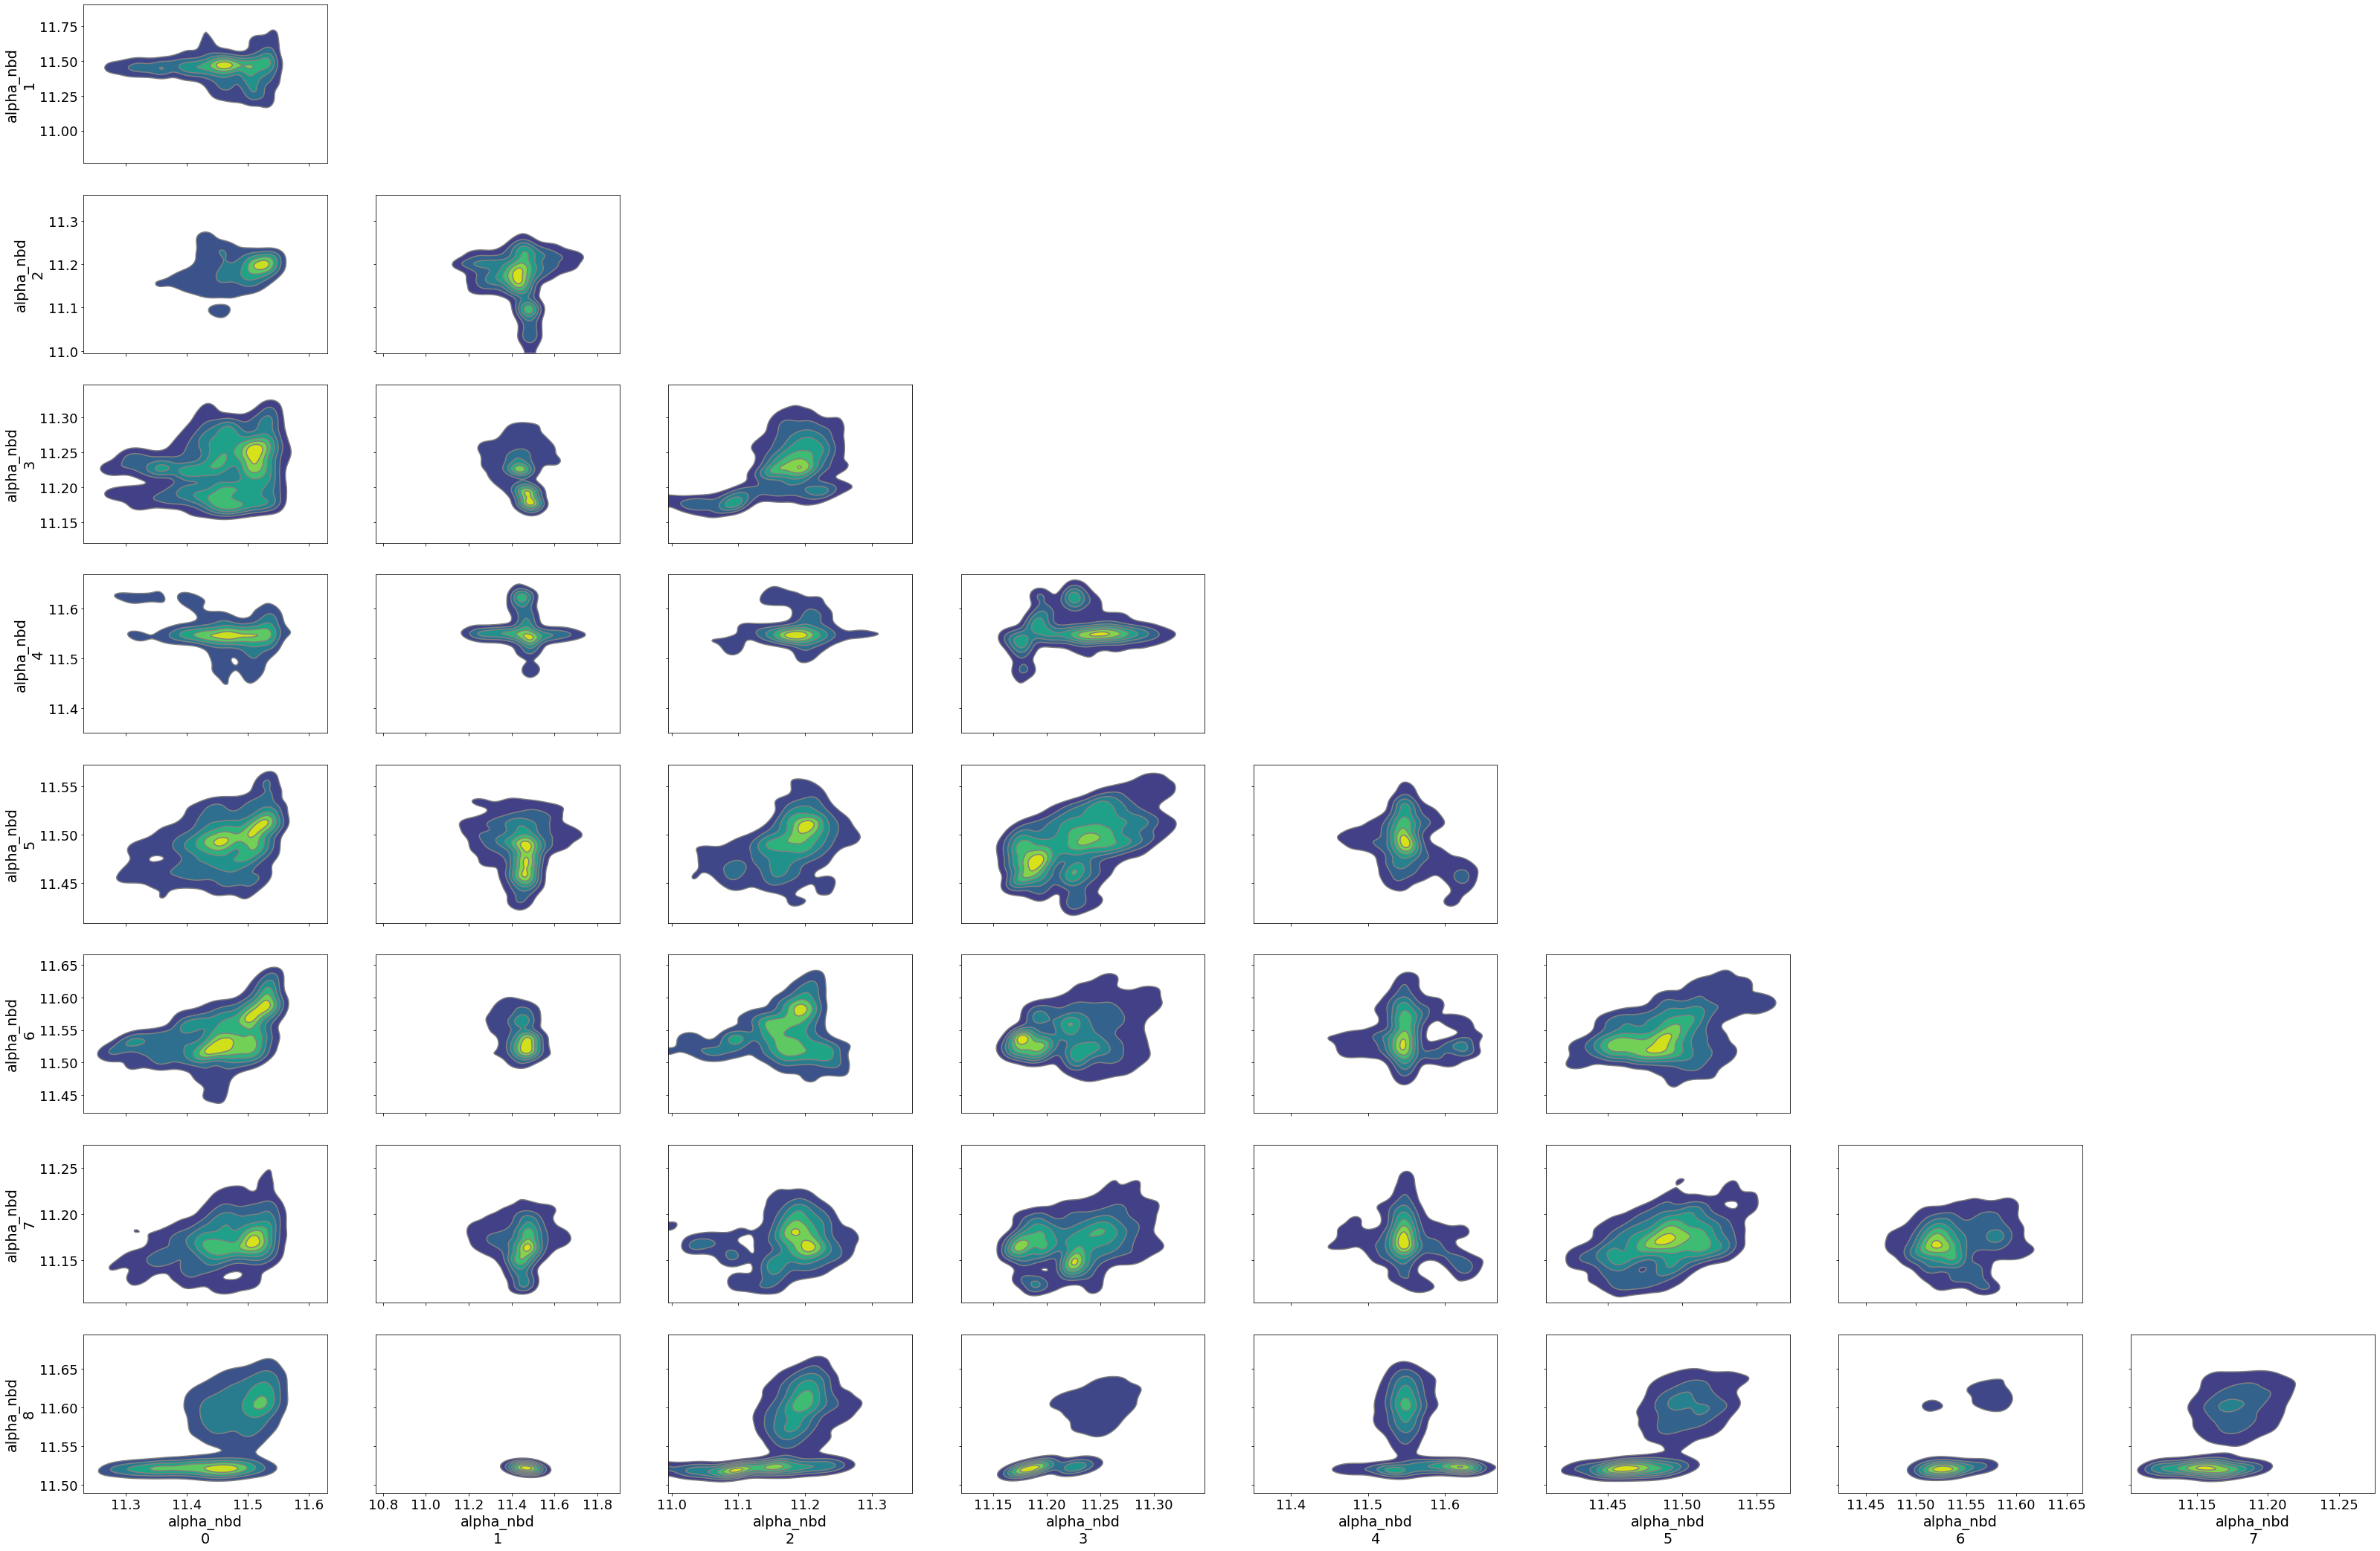

In [15]:
az.plot_pair(trace,
             var_names=['alpha_nbd'],
             kind='kde',
             divergences=False,
             textsize=18)
plt.show()

Edwards
1.3351412682811616


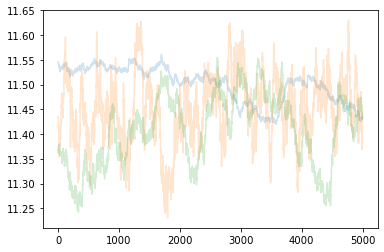

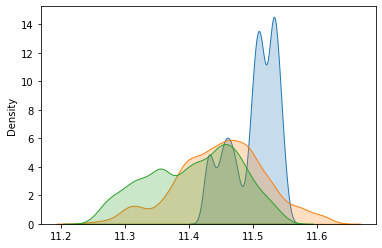

-------
OldTown
1.0263888330583186


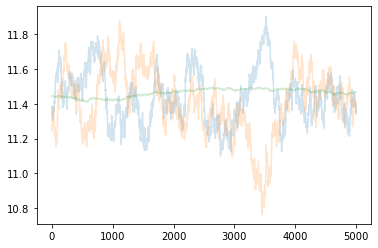

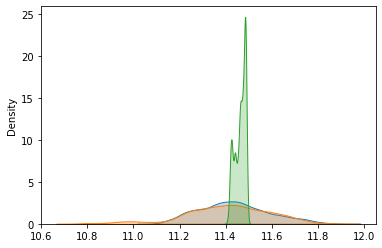

-------
CollgCr
1.3431790169307452


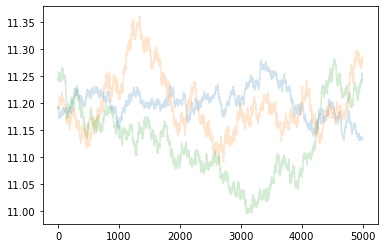

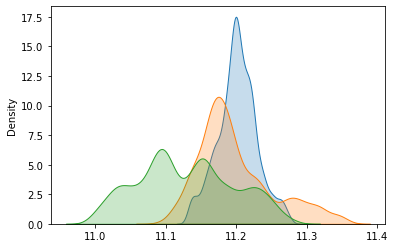

-------
SawyerW
1.4287011961385878


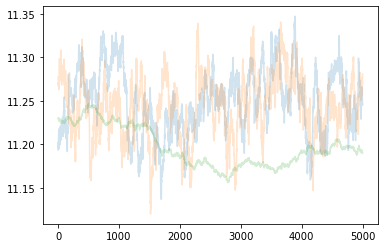

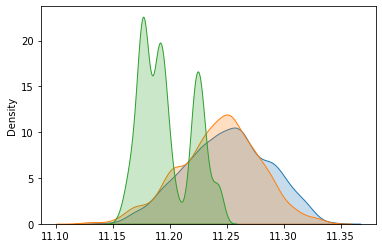

-------
Gilbert
1.1646471687426005


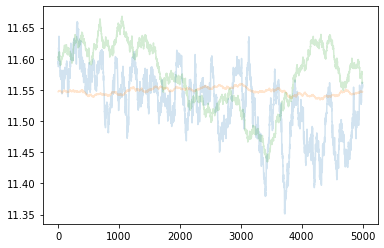

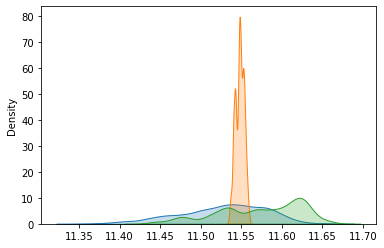

-------
NAmes
1.4409645493252494


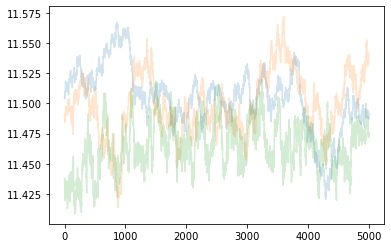

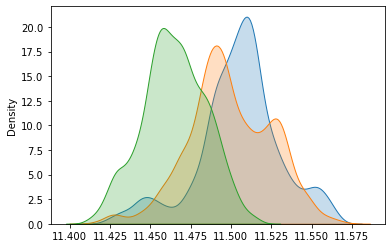

-------
Mitchel
1.0533560812768465


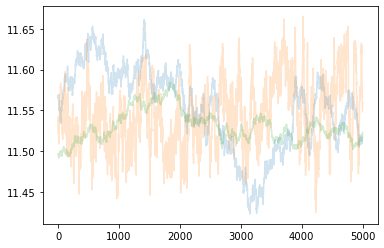

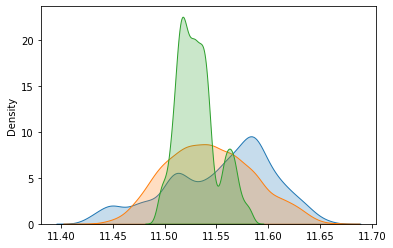

-------
NWAmes
1.2285982859585498


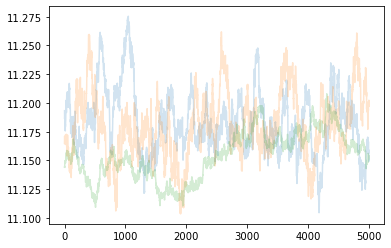

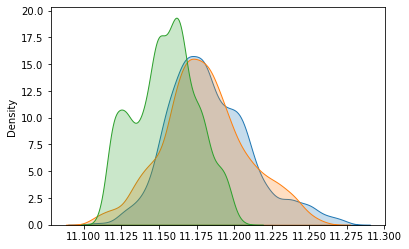

-------
Somerst
2.196248182381085


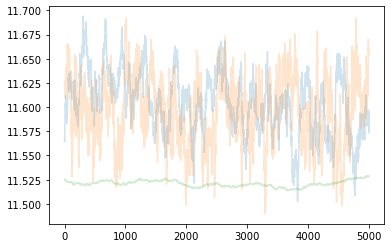

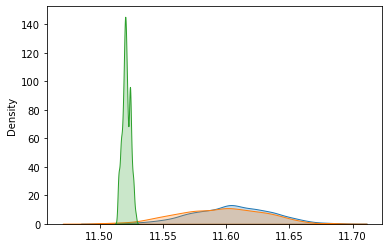

-------
IDOTRR
1.2204039593718279


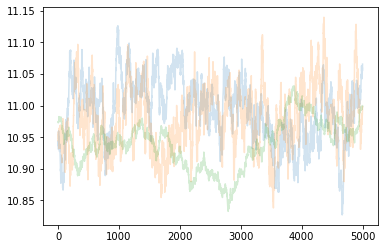

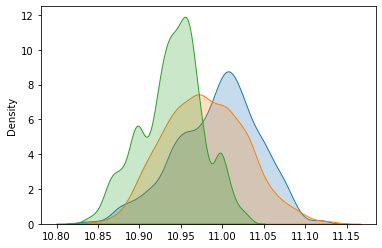

-------
NPkVill
1.018052987407132


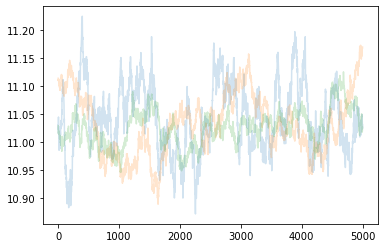

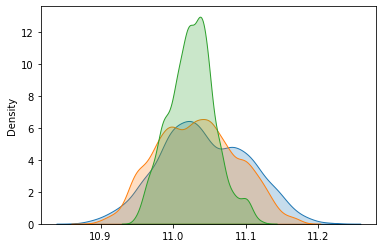

-------
NridgHt
1.4331984061389809


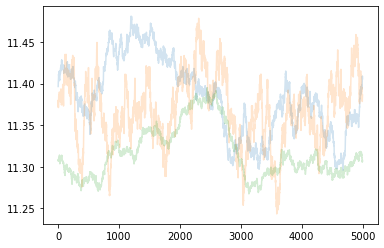

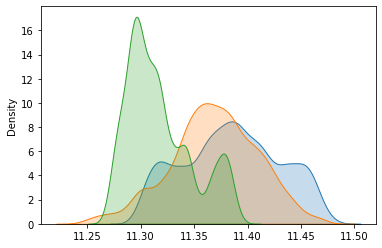

-------
Crawfor
1.5493360925528639


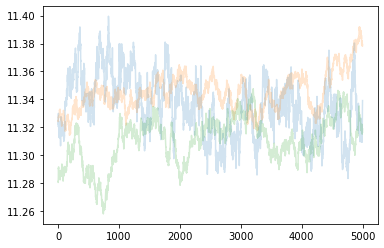

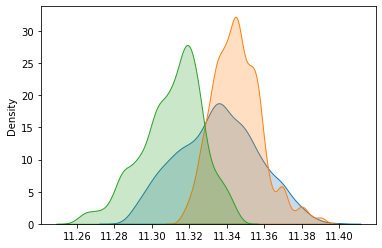

-------
StoneBr
1.9739618844897406


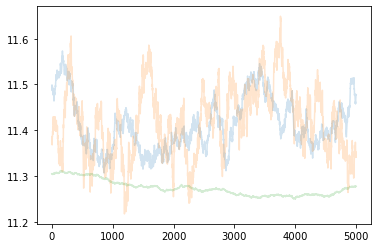

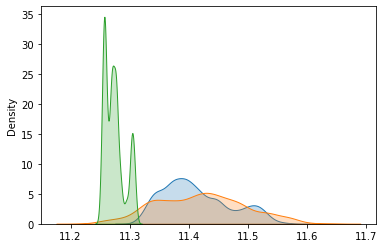

-------
Blmngtn
1.1679386225018187


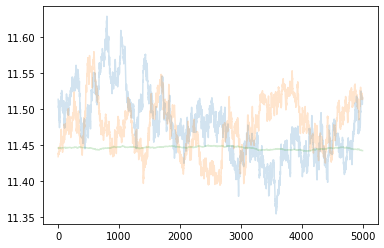

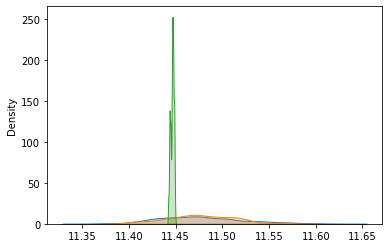

-------
NoRidge
1.1546340494467913


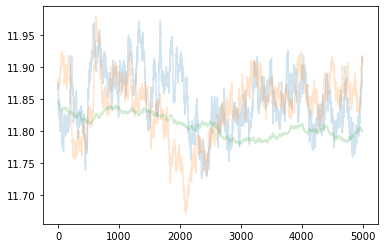

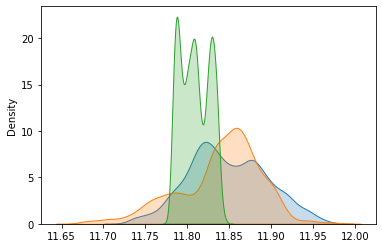

-------
BrkSide
1.0988843157980703


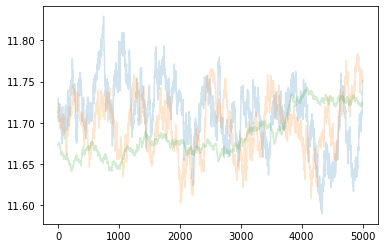

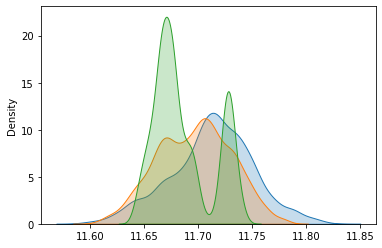

-------
Sawyer
1.0719090290874038


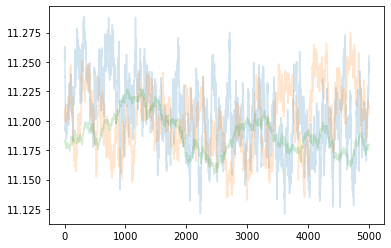

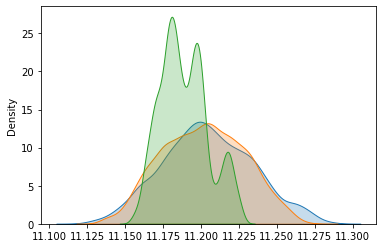

-------
BrDale
1.130912657523525


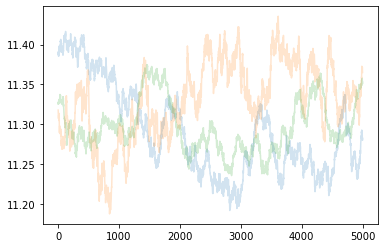

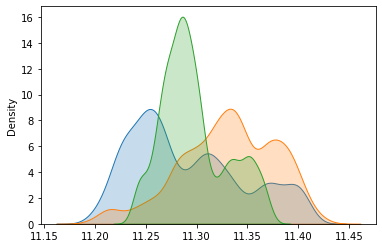

-------
MeadowV
1.7316702377039463


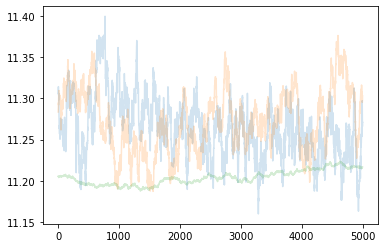

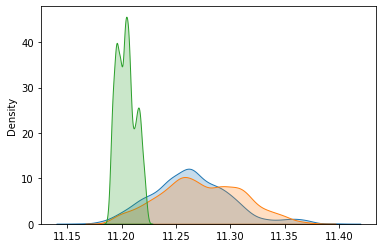

-------
Timber
1.316237618056698


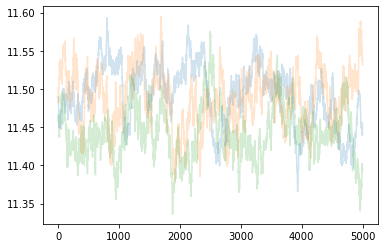

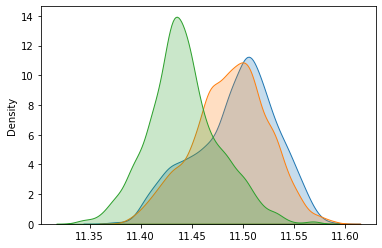

-------
ClearCr
2.17687920033953


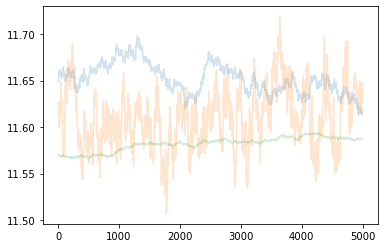

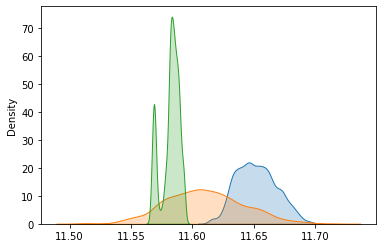

-------
SWISU
1.1928123742122771


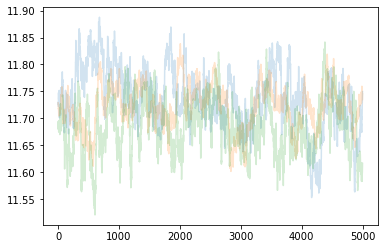

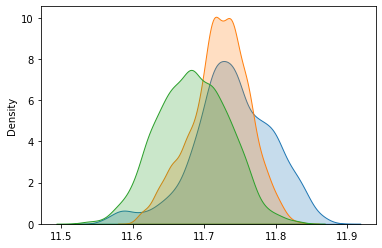

-------
Veenker
1.6150293582398396


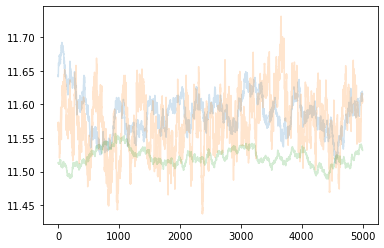

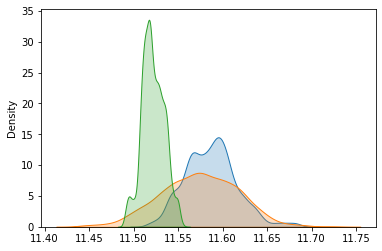

-------
Blueste
1.3116633584654522


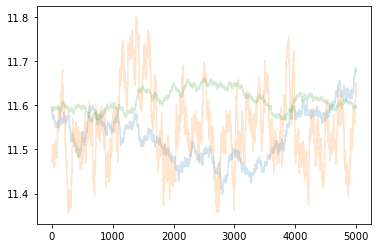

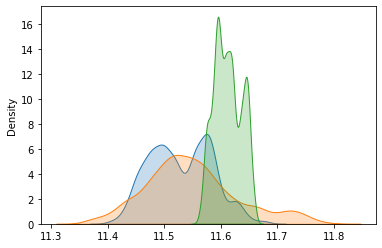

-------


In [16]:
for i in range(n_nbd):
    print(Neighborhoods[i])
    print(calc_Rhat(trace.posterior.alpha_nbd[0,:,i].values,
                    trace.posterior.alpha_nbd[1,:,i].values,
                    trace.posterior.alpha_nbd[2,:,i].values))
    plot_trace(trace.posterior.alpha_nbd[0,:,i].values,
               trace.posterior.alpha_nbd[1,:,i].values,
               trace.posterior.alpha_nbd[2,:,i].values)
    plot_posterior_dists(trace.posterior.alpha_nbd[0,:,i].values,
                         trace.posterior.alpha_nbd[1,:,i].values,
                         trace.posterior.alpha_nbd[2,:,i].values)
    print("-------")

In [17]:
for c in trace_df.columns:
    print(c)

chain
draw
('posterior', 'alpha')
('posterior', 'alpha_nbd[0]', 0)
('posterior', 'alpha_nbd[10]', 10)
('posterior', 'alpha_nbd[11]', 11)
('posterior', 'alpha_nbd[12]', 12)
('posterior', 'alpha_nbd[13]', 13)
('posterior', 'alpha_nbd[14]', 14)
('posterior', 'alpha_nbd[15]', 15)
('posterior', 'alpha_nbd[16]', 16)
('posterior', 'alpha_nbd[17]', 17)
('posterior', 'alpha_nbd[18]', 18)
('posterior', 'alpha_nbd[19]', 19)
('posterior', 'alpha_nbd[1]', 1)
('posterior', 'alpha_nbd[20]', 20)
('posterior', 'alpha_nbd[21]', 21)
('posterior', 'alpha_nbd[22]', 22)
('posterior', 'alpha_nbd[23]', 23)
('posterior', 'alpha_nbd[24]', 24)
('posterior', 'alpha_nbd[2]', 2)
('posterior', 'alpha_nbd[3]', 3)
('posterior', 'alpha_nbd[4]', 4)
('posterior', 'alpha_nbd[5]', 5)
('posterior', 'alpha_nbd[6]', 6)
('posterior', 'alpha_nbd[7]', 7)
('posterior', 'alpha_nbd[8]', 8)
('posterior', 'alpha_nbd[9]', 9)
('posterior', 'beta_uc[0]', 0)
('posterior', 'beta_uc[1]', 1)
('posterior', 'beta_uc[2]', 2)
('posterior', 'bet

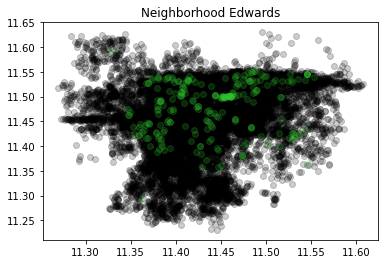

--------


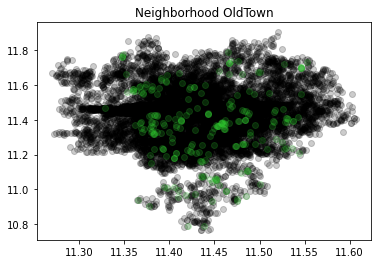

--------


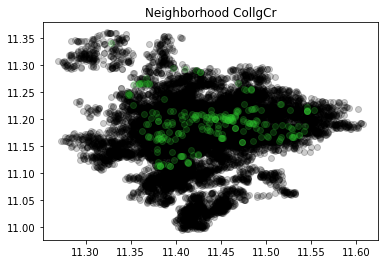

--------


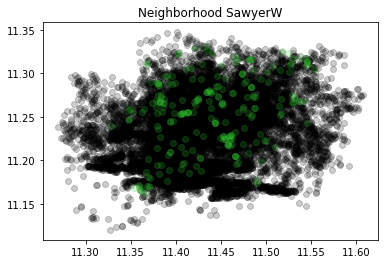

--------


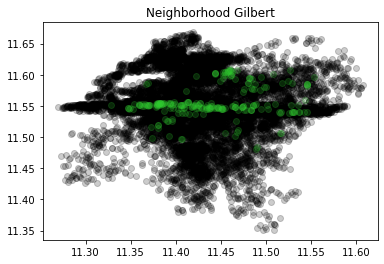

--------


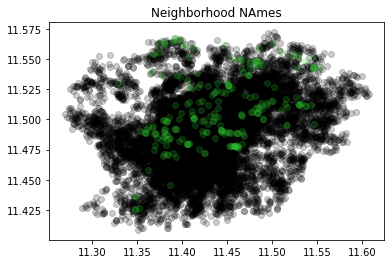

--------


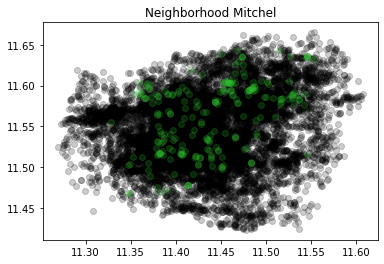

--------


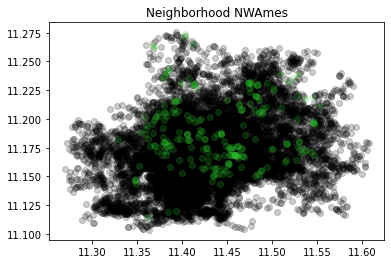

--------


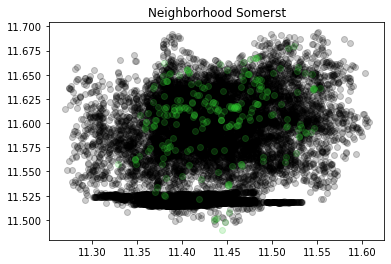

--------


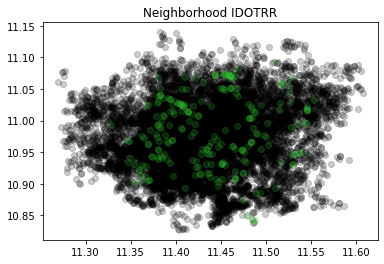

--------


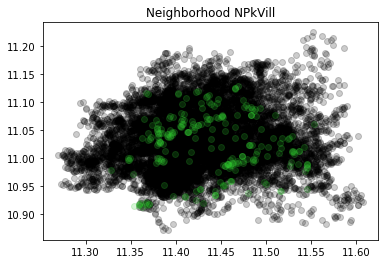

--------


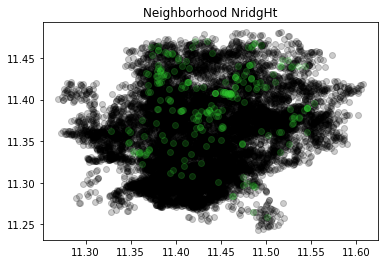

--------


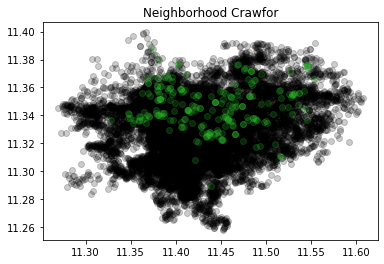

--------


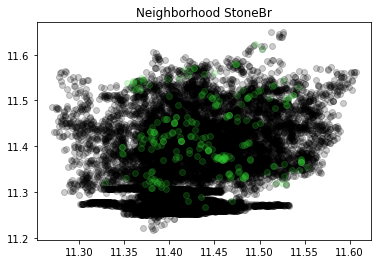

--------


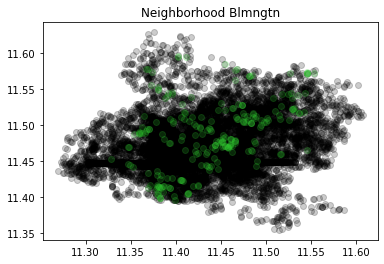

--------


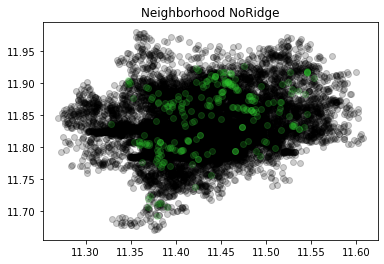

--------


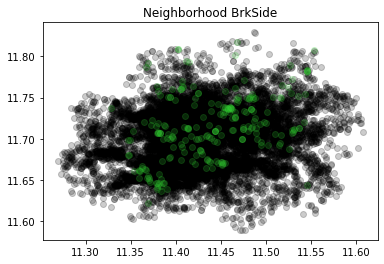

--------


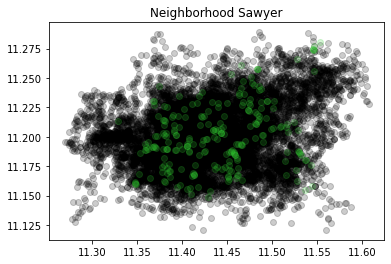

--------


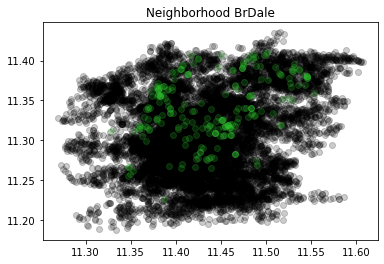

--------


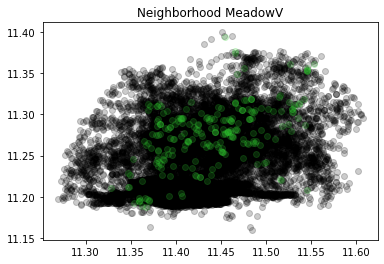

--------


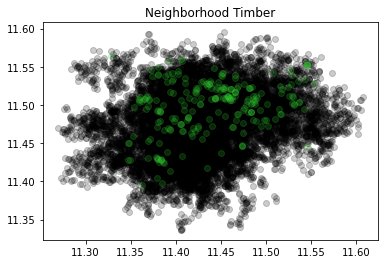

--------


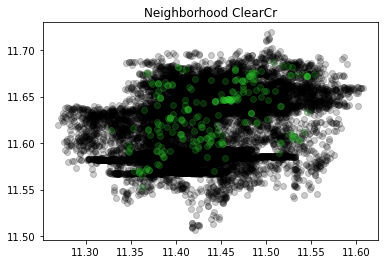

--------


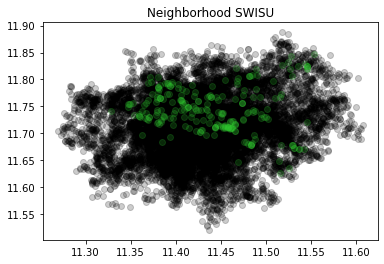

--------


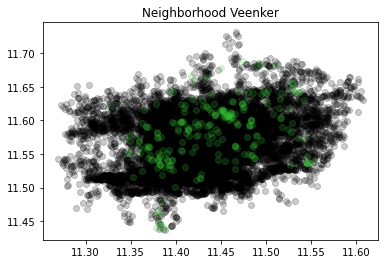

--------


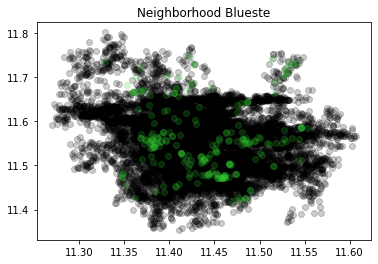

--------


In [18]:
for nbd in range(n_nbd):
    plt.scatter(trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', 'alpha')],
                trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', f'alpha_nbd[{nbd}]', nbd)],
                color="black", alpha=0.2)
    plt.scatter(trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', 'alpha')],
                trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', f'alpha_nbd[{nbd}]', nbd)],
                color="limegreen", alpha=0.2)
    plt.title(f"Neighborhood {Neighborhoods[nbd]}")
    plt.show()
    print("--------")

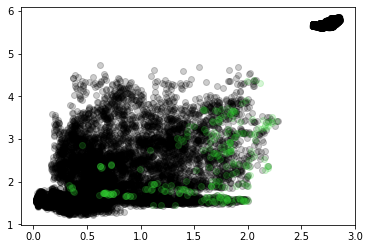

In [19]:
n1 = 0
n2 = 3
plt.scatter(trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n1}]', n1)],
            trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n2}]', n2)],
            color="black", alpha=0.2)
plt.scatter(trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n1}]', n1)],
            trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n2}]', n2)],
            color="limegreen", alpha=0.2)
plt.show()

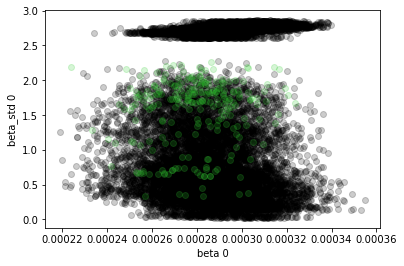

In [20]:
n = 0
plt.scatter(trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', f'beta[{n}]', n)],
            trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n}]', n)],
            color="black", alpha=0.2)
plt.scatter(trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', f'beta[{n}]', n)],
            trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', f'Omega_stds[{n}]', n)],
            color="limegreen", alpha=0.2)
plt.xlabel(f"beta {n}")
plt.ylabel(f"beta_std {n}")
plt.show()

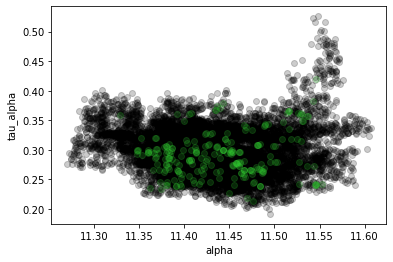

In [21]:
plt.scatter(trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', 'alpha')],
            trace_df[~trace_df[('sample_stats', 'diverging')]][('posterior', 'tau_alpha')],
            color="black", alpha=0.2)
plt.scatter(trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', 'alpha')],
            trace_df[trace_df[('sample_stats', 'diverging')]][('posterior', 'tau_alpha')],
            color="limegreen", alpha=0.2)
plt.xlabel("alpha")
plt.ylabel("tau_alpha")
plt.show()